## Auxiliary loss

This notebook contains the models used to study auxiliary loss. It contains a simple model that is fast to train and one deeper model with two versions that take respectively about 1h and 2h to train on a RTX 2070 (super) GPU.

In [7]:
import torch
from torch import tensor, nn
from loading_datas import  generate_pair_sets
import torch.nn.functional as F



In [8]:
train_pairs, train_target, train_classes, test_pairs, test_target, test_classes = generate_pair_sets(1000)
print(train_target.size(), test_target.size())
# print(train_target)

torch.Size([1000]) torch.Size([1000])


In [9]:
class Net1(nn.Module):
  def __init__(self):
    super(Net1,self).__init__()

    self.conv11 = nn.Conv2d(1,16,3)
    self.conv12 = nn.Conv2d(16,32,3)

    self.conv21 = nn.Conv2d(1,16,3)
    self.conv22 = nn.Conv2d(16,32,3)

    self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=2)

    self.fc1 = nn.Linear(64*4*4,64)
    self.fc2 = nn.Linear(64,32)
    self.fc3 = nn.Linear(32,2)

  def forward(self,x): 
    # spliting the channels
    c1 = torch.narrow(x,1,0,1)
    c2 = torch.narrow(x,1,1,1)

    # Channel 1
    c1 = F.relu(self.conv11(c1))
    c1 = self.pool(c1)
    c1 = F.relu(self.conv12(c1))
    

    # Channel 2
    c2 = F.relu(self.conv21(c2))
    c2 = self.pool(c2)
    c2 = F.relu(self.conv22(c2))
    


    output = torch.cat((c1,c2),1)
    output = output.view(-1,64*4*4)
   
    output = F.relu(self.fc1(output))
    output = F.relu(self.fc2(output))
    output = self.fc3(output)

    return output

class Net1_aux(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv11 = nn.Conv2d(1,16,3)
    self.conv12 = nn.Conv2d(16,32,3)

    self.conv21 = nn.Conv2d(1,16,3)
    self.conv22 = nn.Conv2d(16,32,3)

    self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=2)

    self.fc1 = nn.Linear(64*4*4,64)
    self.fc2 = nn.Linear(64,32)
    self.fc3 = nn.Linear(32,2)

  def aux(self, img1, img2):
    img = output = torch.cat((img1, img2), 1)
    nb_el = img.size()[1] * img.size()[2] * img.size()[3]
    # print(nb_el)
    output = img.view(-1, nb_el)
    # print(output.size())
    fc1_aux = nn.Linear(nb_el, 64)
    output = F.relu(fc1_aux(output))
    output = F.relu(self.fc2(output))
    output = self.fc3(output)
    return output

  def forward(self,x): 
    # spliting the channels
    c1 = torch.narrow(x,1,0,1)
    c2 = torch.narrow(x,1,1,1)

    # Channel 1
    c1 = F.relu(self.conv11(c1))
    c2 = F.relu(self.conv21(c2))
    output_aux1 = self.aux(c1, c2)

    c1 = self.pool(c1)
    c2 = self.pool(c2)
    output_aux2 = self.aux(c1, c2)

    

    c1 = F.relu(self.conv12(c1))
    c2 = F.relu(self.conv22(c2))
    


    output = torch.cat((c1,c2),1)
    output = output.view(-1,64*4*4)
   
    output = F.relu(self.fc1(output))
    output = F.relu(self.fc2(output))
    output = self.fc3(output)

    return output, output_aux1, output_aux2



## Deeper models

In [10]:
class Net1_deep(nn.Module):
  def __init__(self):
    super().__init__()
    #channel 1
    self.conv11 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1)
    self.conv12 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=2)
    self.conv13 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(3, 3), padding=1)
    self.conv14 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1)
    self.conv15 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1)

    #channel 2
    self.conv21 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1)
    self.conv22 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=2)
    self.conv23 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(3, 3), padding=1)
    self.conv24 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1)
    self.conv25 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1)

    self.maxPool = nn.MaxPool2d(kernel_size=(2, 2))



    self.fc1 = nn.Linear(512*3*3, 512)
    self.fc2 = nn.Linear(512, 64)
    self.fc3 = nn.Linear(64, 2)

  def forward(self,x): 
    # spliting the channels
    c1 = torch.narrow(x,1,0,1)
    c2 = torch.narrow(x,1,1,1)

    # Channel 1
    c1 = F.relu(self.conv11(c1))  #16 x 14 x 14
    c1 = F.relu(self.conv12(c1))  # 32 x 13 x 13
    c1 = self.maxPool(c1)
    c1 = F.relu(self.conv13(c1))  # 64 x 7 x 7
    c1 = F.relu(self.conv14(c1))  # 128 x 6 x 6
    c1 = F.relu(self.conv15(c1))  # 256 x 6 x 6
    c1 = self.maxPool(c1)  # 256 x 3 x 3

    # Channel 2
    c2 = F.relu(self.conv21(c2))  # 16 x 14 x 14
    c2 = F.relu(self.conv22(c2))  # 32 x 13 x 13
    c2 = self.maxPool(c2)
    c2 = F.relu(self.conv23(c2))  # 64 x 7 x 7
    c2 = F.relu(self.conv24(c2))  # 128 x 6 x 6
    c2 = F.relu(self.conv25(c2))  # 256 x 6 x 6
    c2 = self.maxPool(c2)  # 256 x 3 x 3





    output = torch.cat((c1,c2),1)

    output = output.view(-1,512*3*3)

    output = F.relu(self.fc1(output))
    output = F.relu(self.fc2(output))
    output = self.fc3(output)

    return output

class Net1_deep_aux(nn.Module):
  def __init__(self):
    super().__init__()
    #channel 1
    self.conv11 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1)
    self.conv12 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=2)
    self.conv13 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(3, 3), padding=1)
    self.conv14 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1)
    self.conv15 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1)

    #channel 2
    self.conv21 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1)
    self.conv22 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=2)
    self.conv23 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(3, 3), padding=1)
    self.conv24 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1)
    self.conv25 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1)

    self.maxPool = nn.MaxPool2d(kernel_size=(2, 2))



    self.fc1 = nn.Linear(512*3*3, 512)
    self.fc2 = nn.Linear(512, 64)
    self.fc3 = nn.Linear(64, 2)

  def aux(self, img1, img2):
    
    img = output = torch.cat((img1, img2), 1)
    nb_el = img.size()[1] * img.size()[2] * img.size()[3]
    # print(nb_el)
    output = img.view(-1, nb_el)
    # print(output.size())
    fc1_aux = nn.Linear(nb_el, 512)
    output = F.relu(fc1_aux(output))
    output = F.relu(self.fc2(output))
    output = self.fc3(output)
    return output

  def forward(self,x): 
    # spliting the channels
    c1 = torch.narrow(x,1,0,1)
    c2 = torch.narrow(x,1,1,1)

    # Channel 1
    c1 = F.relu(self.conv11(c1))  #16 x 14 x 14
    c2 = F.relu(self.conv21(c2))  # 16 x 14 x 14
    output1 = self.aux(c1, c2)


    # Channel 2
    c1 = F.relu(self.conv12(c1))  # 32 x 13 x 13
    c2 = F.relu(self.conv22(c2))  # 32 x 13 x 13

    
    c1 = self.maxPool(c1)
    c2 = self.maxPool(c2)
    output2 = self.aux(c1, c2)


    c1 = F.relu(self.conv13(c1))  # 64 x 7 x 7
    c2 = F.relu(self.conv23(c2))  # 64 x 7 x 7


    c1 = F.relu(self.conv14(c1))  # 128 x 6 x 6
    c2 = F.relu(self.conv24(c2))  # 128 x 6 x 6

    
    output3 = self.aux(c1, c2)

    c1 = F.relu(self.conv15(c1))  # 256 x 6 x 6
    c2 = F.relu(self.conv25(c2))  # 256 x 6 x 6
    c1 = self.maxPool(c1)  # 256 x 3 x 3
    c2 = self.maxPool(c2)  # 256 x 3 x 3

    



    output = torch.cat((c1,c2),1)

    output = output.view(-1,512*3*3)

    output = F.relu(self.fc1(output))
    output = F.relu(self.fc2(output))
    output = self.fc3(output)

    return output, output1, output2, output3


class Net1_deep_classes(nn.Module):
  def __init__(self):
    super().__init__()
    #channel 1
    self.conv11 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1)
    self.conv12 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=2)
    self.conv13 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(3, 3), padding=1)
    self.conv14 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1)
    self.conv15 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1)

    #channel 2
    self.conv21 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1)
    self.conv22 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5), padding=2)
    self.conv23 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=(3, 3), padding=1)
    self.conv24 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1)
    self.conv25 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1)

    self.maxPool = nn.MaxPool2d(kernel_size=(2, 2))



    self.fc1 = nn.Linear(512*3*3, 512)
    self.fc2 = nn.Linear(512, 64)
    self.fc3 = nn.Linear(64, 2)
    self.fc4 = nn.Linear(64, 10)

  def forward(self,x): 
    # spliting the channels
    c1 = torch.narrow(x,1,0,1)
    c2 = torch.narrow(x,1,1,1)

    # Channel 1
    c1 = F.relu(self.conv11(c1))  #16 x 14 x 14
    c1 = F.relu(self.conv12(c1))  # 32 x 13 x 13
    c1 = self.maxPool(c1)
    c1 = F.relu(self.conv13(c1))  # 64 x 7 x 7
    c1 = F.relu(self.conv14(c1))  # 128 x 6 x 6
    c1 = F.relu(self.conv15(c1))  # 256 x 6 x 6
    c1 = self.maxPool(c1)  # 256 x 3 x 3

    # Channel 2
    c2 = F.relu(self.conv21(c2))  # 16 x 14 x 14
    c2 = F.relu(self.conv22(c2))  # 32 x 13 x 13
    c2 = self.maxPool(c2)
    c2 = F.relu(self.conv23(c2))  # 64 x 7 x 7
    c2 = F.relu(self.conv24(c2))  # 128 x 6 x 6
    c2 = F.relu(self.conv25(c2))  # 256 x 6 x 6
    c2 = self.maxPool(c2)  # 256 x 3 x 3





    output = torch.cat((c1,c2),1)

    output = output.view(-1,512*3*3)

    output = F.relu(self.fc1(output))
    output = F.relu(self.fc2(output))
    prediction = self.fc3(output)
    aux_1 = self.fc4(output)
    aux_2 = self.fc4(output)


    return torch.cat((prediction,aux_1,aux_2),1)


In [11]:
def compute_nb_errors(model, data_input, data_target, batch_size, aux):

    nb_data_errors = 0

    for inputs, targets in zip(data_input.split(batch_size), data_target.split(batch_size)):
        if aux == 1:
            output = model(inputs)[0]
        else:
            output = model(inputs)

        _, predicted_classes = torch.max(output.narrow(1, 0, 2), 1)
        for k in range(len(targets)):
            if targets[k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1
    return nb_data_errors


In [12]:
def training_model(model,
                   train_input,train_target,train_classes,
                   test_input,test_target,
                   eta,epochs = 25,
                   batch_size = 50,
                   auxiliary_loss = True):
  
  test_acc = [0] * epochs

  # define criterion and optimizer
  # need to check the other possibilities
  criterion = nn.CrossEntropyLoss()
  aux_criterion = nn.NLLLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = eta)


  

  for e in range(0,epochs):

    for inputs,target,classes in zip(train_input.split(batch_size),train_target.split(batch_size),train_classes.split(batch_size)):


      if auxiliary_loss == 2:
        outputs = model(inputs)

        prediction = outputs.narrow(1,0,2)
        aux_1 = outputs.narrow(1,2,10)
        aux_2 = outputs.narrow(1,12,10)

        loss = criterion(prediction, target) 
        loss_1 = aux_criterion(torch.sigmoid(aux_1), classes[:,0]) 
        loss_2 = aux_criterion(torch.sigmoid(aux_2), classes[:,1]) 
        # print(loss_1)

        loss += loss_1 + loss_2

      if auxiliary_loss == 1:
        # output, output_aux1, output_aux2 = model(inputs)
        outputs = model(inputs)
        output = outputs[0]
        output_aux1 = outputs[1]
        output_aux2 = outputs[2]
        loss = criterion(output, target)
        loss_1 = criterion(output_aux1, target)
        loss_2 = criterion(output_aux2, target)
        loss += loss_1 + loss_2

        if len(outputs) == 4:
          output_aux3 = outputs[3]
          loss_3 = criterion(output_aux3, target)
          loss += loss_3

        

      else : 
        outputs = model(inputs)
        loss = criterion(outputs, target)

      # optimising parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step() 

  
    # train_acc = 0
    train_acc = 100 * (1 - compute_nb_errors(model, train_input, train_target,batch_size, auxiliary_loss)/train_input.size(0))
    test_acc[e] = 100 * (1 - compute_nb_errors(model, test_input, test_target,batch_size, auxiliary_loss)/test_input.size(0))
    # print(f"Epoch # {e+1} / Train accuracy (%): {train_acc:.2f} / Test accuracy (%): {test_acc[e]:.2f}")
     


  return test_acc

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot(label_1, label_2, name, epochs, test_acc1, test_acc2):
  

  Model_1_mean = [0] * epochs
  Model_1_std = [0] * epochs
  Model_2_mean = [0] * epochs
  Model_2_std = [0] * epochs
#   Model_3_mean = [0] * epochs
#   Model_3_std = [0] * epochs

  test_acc_1_copy = list.copy(test_acc1)
  test_acc_2_copy = list.copy(test_acc2)

  test_acc_1 = []
  test_acc_2 = []

  for row in test_acc_1_copy:
    new_row = row[-epochs:]
    # new_row.reverse()
    test_acc_1.append(new_row)
  for row in test_acc_2_copy:
    new_row = row[-epochs:]
    # new_row.reverse()
    test_acc_2.append(new_row)

  

  for e in range(epochs):
    Model_1_mean[e] = np.mean([row[e] for row in test_acc_1])
    Model_1_std[e] = np.std([row[e] for row in test_acc_1])
    Model_2_mean[e] = np.mean([row[e] for row in test_acc_2])
    Model_2_std[e] = np.std([row[e] for row in test_acc_2])
    # Model_3_mean[e] = np.mean([row[e] for row in test_acc_3])
    # Model_3_std[e] = np.std([row[e] for row in test_acc_3])

  print('Results for model 1')
  print(Model_1_mean[-1])
  print(Model_1_std[-1])

  print('Results for model 2')
  print(Model_2_mean[-1])
  print(Model_2_std[-1])


  # print(np.mean(Model_2_mean))
  # print("***")
  # print(np.min(Model_1_std))
  # print(np.max(Model_1_std))
  # print("***")
  # print(np.min(Model_2_std))
  # print(np.max(Model_2_std))
  # print("***")


  epochs_x = list(range(1, epochs+1))
  fig, ax = plt.subplots()
  plt.grid()

  ax.plot(epochs_x, Model_1_mean, color='r', label=label_1)
  ax.fill_between(epochs_x, ([x1 - x2 for (x1, x2) in zip(Model_1_mean, Model_1_std)]),
                  ([x1 + x2 for (x1, x2) in zip(Model_1_mean, Model_1_std)]), color='r', alpha=0.1)

  ax.plot(epochs_x, Model_2_mean, color='b', label=label_2)
  ax.fill_between(epochs_x, ([x1 - x2 for (x1, x2) in zip(Model_2_mean, Model_2_std)]),
                  ([x1 + x2 for (x1, x2) in zip(Model_2_mean, Model_2_std)]), color='b', alpha=0.1)

#   ax.plot(epochs_x, Model_3_mean, color='g', label=label_3)
#   ax.fill_between(epochs_x, ([x1 - x2 for (x1, x2) in zip(Model_3_mean, Model_3_std)]),
                #   ([x1 + x2 for (x1, x2) in zip(Model_3_mean, Model_3_std)]), color='g', alpha=0.1)

  plt.legend()
  fig.set_size_inches(12, 8)
  fig.set_dpi(300)
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('Test Accuracy [%]', fontsize=10)
  plt.savefig(f'{name}.png')
  plt.show()

In [14]:
lr, nb_epochs, batch_size = 0.01, 30, 50


## Performance evaluation

### Runs

In [15]:
from time import perf_counter

nb_round = 50
N = 1000

test_acc_1 = []
time_1_1 = []
test_acc_2 = []
time_2_1 = []

lr, nb_epochs, batch_size = 0.01, 60, 50


for i in range(nb_round):
  print(i)
  # Dataset
  torch.set_default_tensor_type(torch.cuda.FloatTensor if torch.cuda.is_available()
                                else torch.FloatTensor)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  # print(device)


  train_pairs, train_target, train_classes, test_pairs, test_target, test_classes = generate_pair_sets(
      1000)
  train_pairs = train_pairs.to(device)
  train_target = train_target.to(device)
  train_classes = train_classes.to(device)
  test_pairs = test_pairs.to(device)
  test_target = test_target.to(device)
  test_classes = test_classes.to(device)
  # Models
  model1 = Net1()  #  change here to different model
  model2 = Net1_aux()  #  change here to different model

  start = perf_counter()
  test_acc_1.append(training_model(model1, train_pairs, train_target, train_classes, test_pairs,
                    test_target, eta=lr, epochs=nb_epochs, batch_size=batch_size, auxiliary_loss=0))
  end = perf_counter()
  time_1_1.append(end-start)

  start = perf_counter()
  test_acc_2.append(training_model(model2, train_pairs, train_target, train_classes, test_pairs,
                                   test_target, eta=0.75*lr, epochs=nb_epochs, batch_size=batch_size, auxiliary_loss=1))
  end = perf_counter()
  time_2_1.append(end-start)
print('finish')


0
Epoch # 1 / Train accuracy (%): 76.40 / Test accuracy (%): 71.00
Epoch # 2 / Train accuracy (%): 78.80 / Test accuracy (%): 72.50
Epoch # 3 / Train accuracy (%): 82.90 / Test accuracy (%): 77.20
Epoch # 4 / Train accuracy (%): 85.00 / Test accuracy (%): 78.60
Epoch # 5 / Train accuracy (%): 88.80 / Test accuracy (%): 81.00
Epoch # 6 / Train accuracy (%): 90.50 / Test accuracy (%): 82.30
Epoch # 7 / Train accuracy (%): 91.20 / Test accuracy (%): 82.00
Epoch # 8 / Train accuracy (%): 92.30 / Test accuracy (%): 82.40
Epoch # 9 / Train accuracy (%): 91.90 / Test accuracy (%): 81.60
Epoch # 10 / Train accuracy (%): 92.20 / Test accuracy (%): 81.20
Epoch # 11 / Train accuracy (%): 94.80 / Test accuracy (%): 82.60
Epoch # 12 / Train accuracy (%): 97.60 / Test accuracy (%): 84.90
Epoch # 13 / Train accuracy (%): 98.40 / Test accuracy (%): 84.70
Epoch # 14 / Train accuracy (%): 98.00 / Test accuracy (%): 84.40
Epoch # 15 / Train accuracy (%): 99.30 / Test accuracy (%): 84.10
Epoch # 16 / Trai

KeyboardInterrupt: 

Results for model 1
85.81199999999998
1.5031486952394313
Results for model 2
85.51199999999999
1.270848535428201


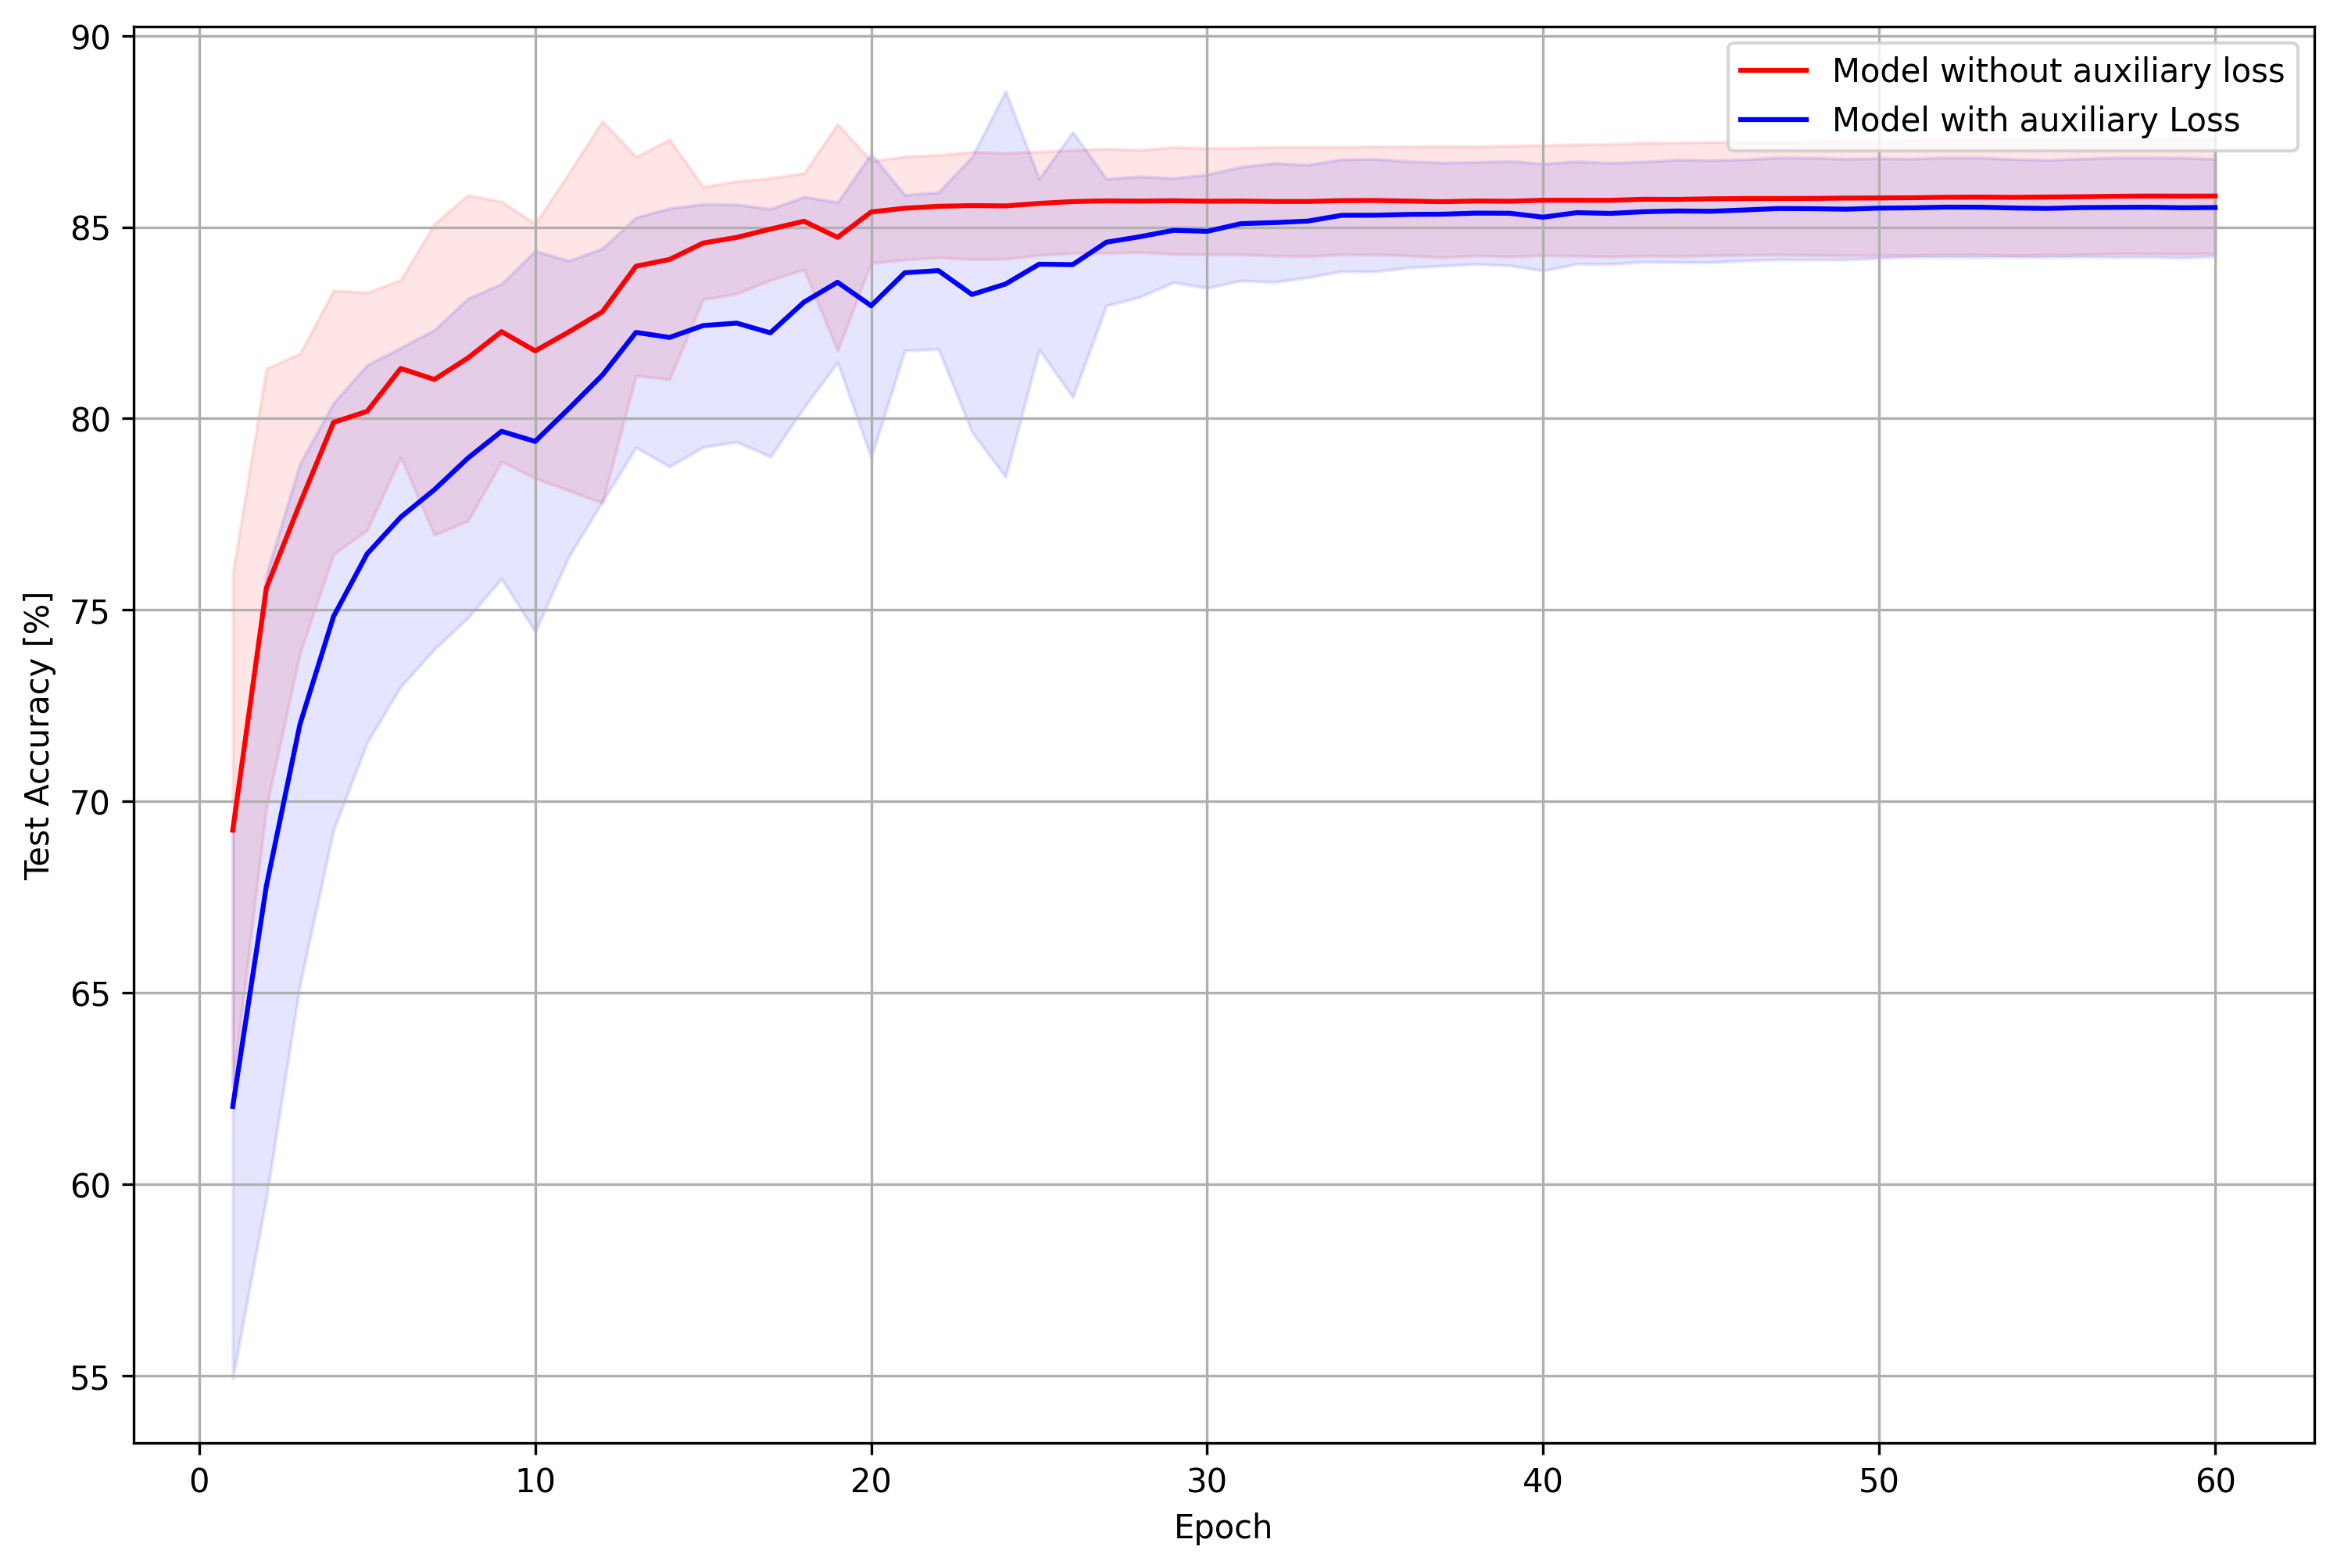

In [ ]:
plot('Model without auxiliary loss','Model with auxiliary Loss', 'basic_model', nb_epochs, test_acc_1, test_acc_2)

In [ ]:
print(np.mean(time_1_1), np.std(time_1_1))
print(np.mean(time_2_1), np.std(time_2_1))

11.254109241999613 0.09336453778686131
14.16176255599974 0.07629933732228927


In [ ]:
from time import perf_counter

nb_round = 50
N = 1000
epochs = 125

test_acc_1_2 = []
time_1_2 = []
test_acc_2_2 = []
time_2_2 = []

lr, nb_epochs, batch_size = 0.01, epochs, 50


for i in range(nb_round):
  print(i)
  # Dataset
  torch.set_default_tensor_type(torch.cuda.FloatTensor if torch.cuda.is_available()
                                else torch.FloatTensor)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  # print(device)

  train_pairs, train_target, train_classes, test_pairs, test_target, test_classes = generate_pair_sets(
      1000)
  train_pairs = train_pairs.to(device)
  train_target = train_target.to(device)
  train_classes = train_classes.to(device)
  test_pairs = test_pairs.to(device)
  test_target = test_target.to(device)
  test_classes = test_classes.to(device)
  # Models
  model1 = Net1_deep()  #  change here to different model
  model2 = Net1_deep_aux()  #  change here to different model

  start = perf_counter()
  test_acc_1_2.append(training_model(model1, train_pairs, train_target, train_classes, test_pairs,
                    test_target, eta=lr, epochs=nb_epochs, batch_size=batch_size, auxiliary_loss=0))
  end = perf_counter()
  time_1_2.append(end-start)

  start = perf_counter()
  test_acc_2_2.append(training_model(model2, train_pairs, train_target, train_classes, test_pairs,
                                   test_target, eta=lr/5, epochs=nb_epochs, batch_size=batch_size, auxiliary_loss=1))
  end = perf_counter()
  time_2_2.append(end-start)
print('finish')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
finish


Results for model 1
87.696
1.2120990058571957
Results for model 2
87.112
1.0715670767618815


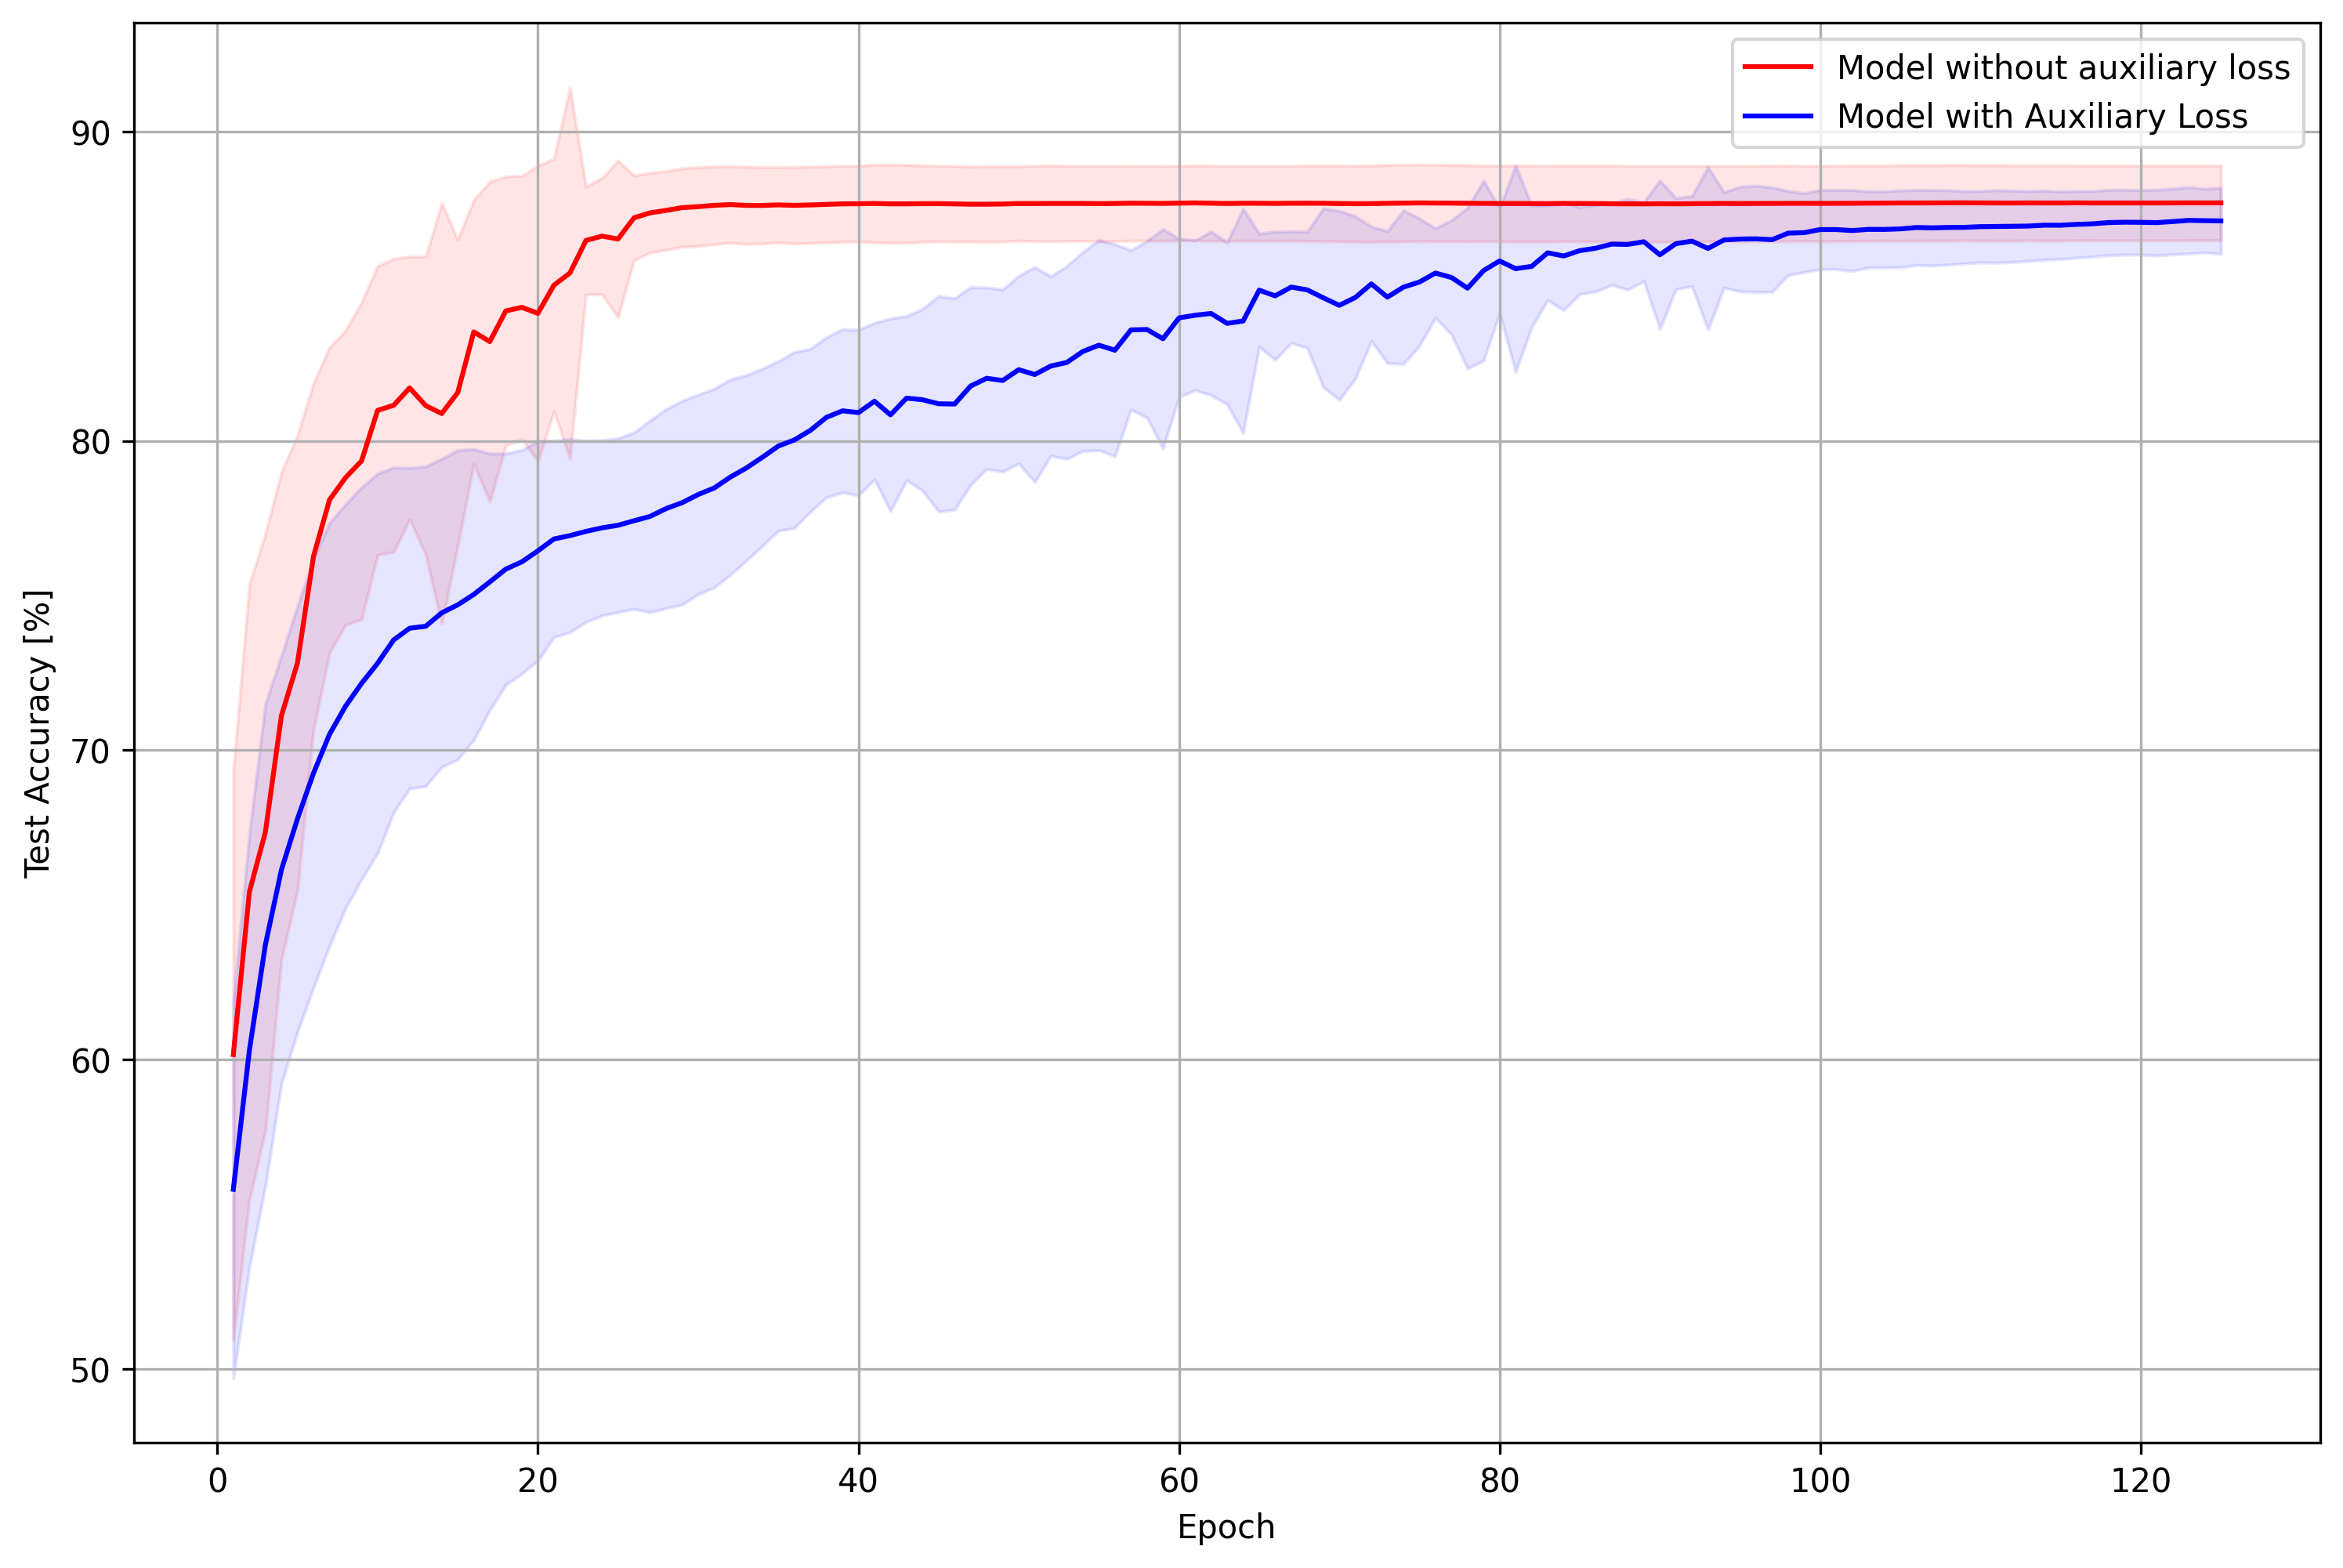

In [ ]:
plot('Model without auxiliary loss', 'Model with Auxiliary Loss', 'deep_model', 125, test_acc_1_2, test_acc_2_2)


In [40]:
print(np.mean(time_1_2), np.std(time_1_2))
print(np.mean(time_2_2), np.std(time_2_2))

33.646600197999945 0.3246475254604291
43.88976427799993 0.3989600939435878


In [41]:
from time import perf_counter

nb_round = 50
N = 1000
# epochs = 50

test_acc_1_3 = []
time_1_3 = []
test_acc_2_3 = []
time_2_3 = []

lr, nb_epochs, batch_size = 3e-4, 50, 50


for i in range(nb_round):
  
  print(i)
  # Dataset
  torch.set_default_tensor_type(torch.cuda.FloatTensor if torch.cuda.is_available()
                                else torch.FloatTensor)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  # print(device)

  train_pairs, train_target, train_classes, test_pairs, test_target, test_classes = generate_pair_sets(
      1000)
  train_pairs = train_pairs.to(device)
  train_target = train_target.to(device)
  train_classes = train_classes.to(device)
  test_pairs = test_pairs.to(device)
  test_target = test_target.to(device)
  test_classes = test_classes.to(device)
  # Models
  model1 = Net1_deep()  #  change here to different model
  model2 = Net1_deep_classes()  #  change here to different model

  start = perf_counter()
  test_acc_1_3.append(training_model(model1, train_pairs, train_target, train_classes, test_pairs,
                    test_target, eta=0.01, epochs=50, batch_size=batch_size, auxiliary_loss=0))
  end = perf_counter()
  time_1_3.append(end-start)

  start = perf_counter()
  test_acc_2_3.append(training_model(model2, train_pairs, train_target, train_classes, test_pairs,
                                   test_target, eta=3e-4, epochs=400, batch_size=batch_size, auxiliary_loss=2))
  end = perf_counter()
  time_2_3.append(end-start)
print('finish')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
finish


Results for model 1
87.36399999999999
0.884253357358625
Results for model 2
86.56400000000002
1.3195089995903795


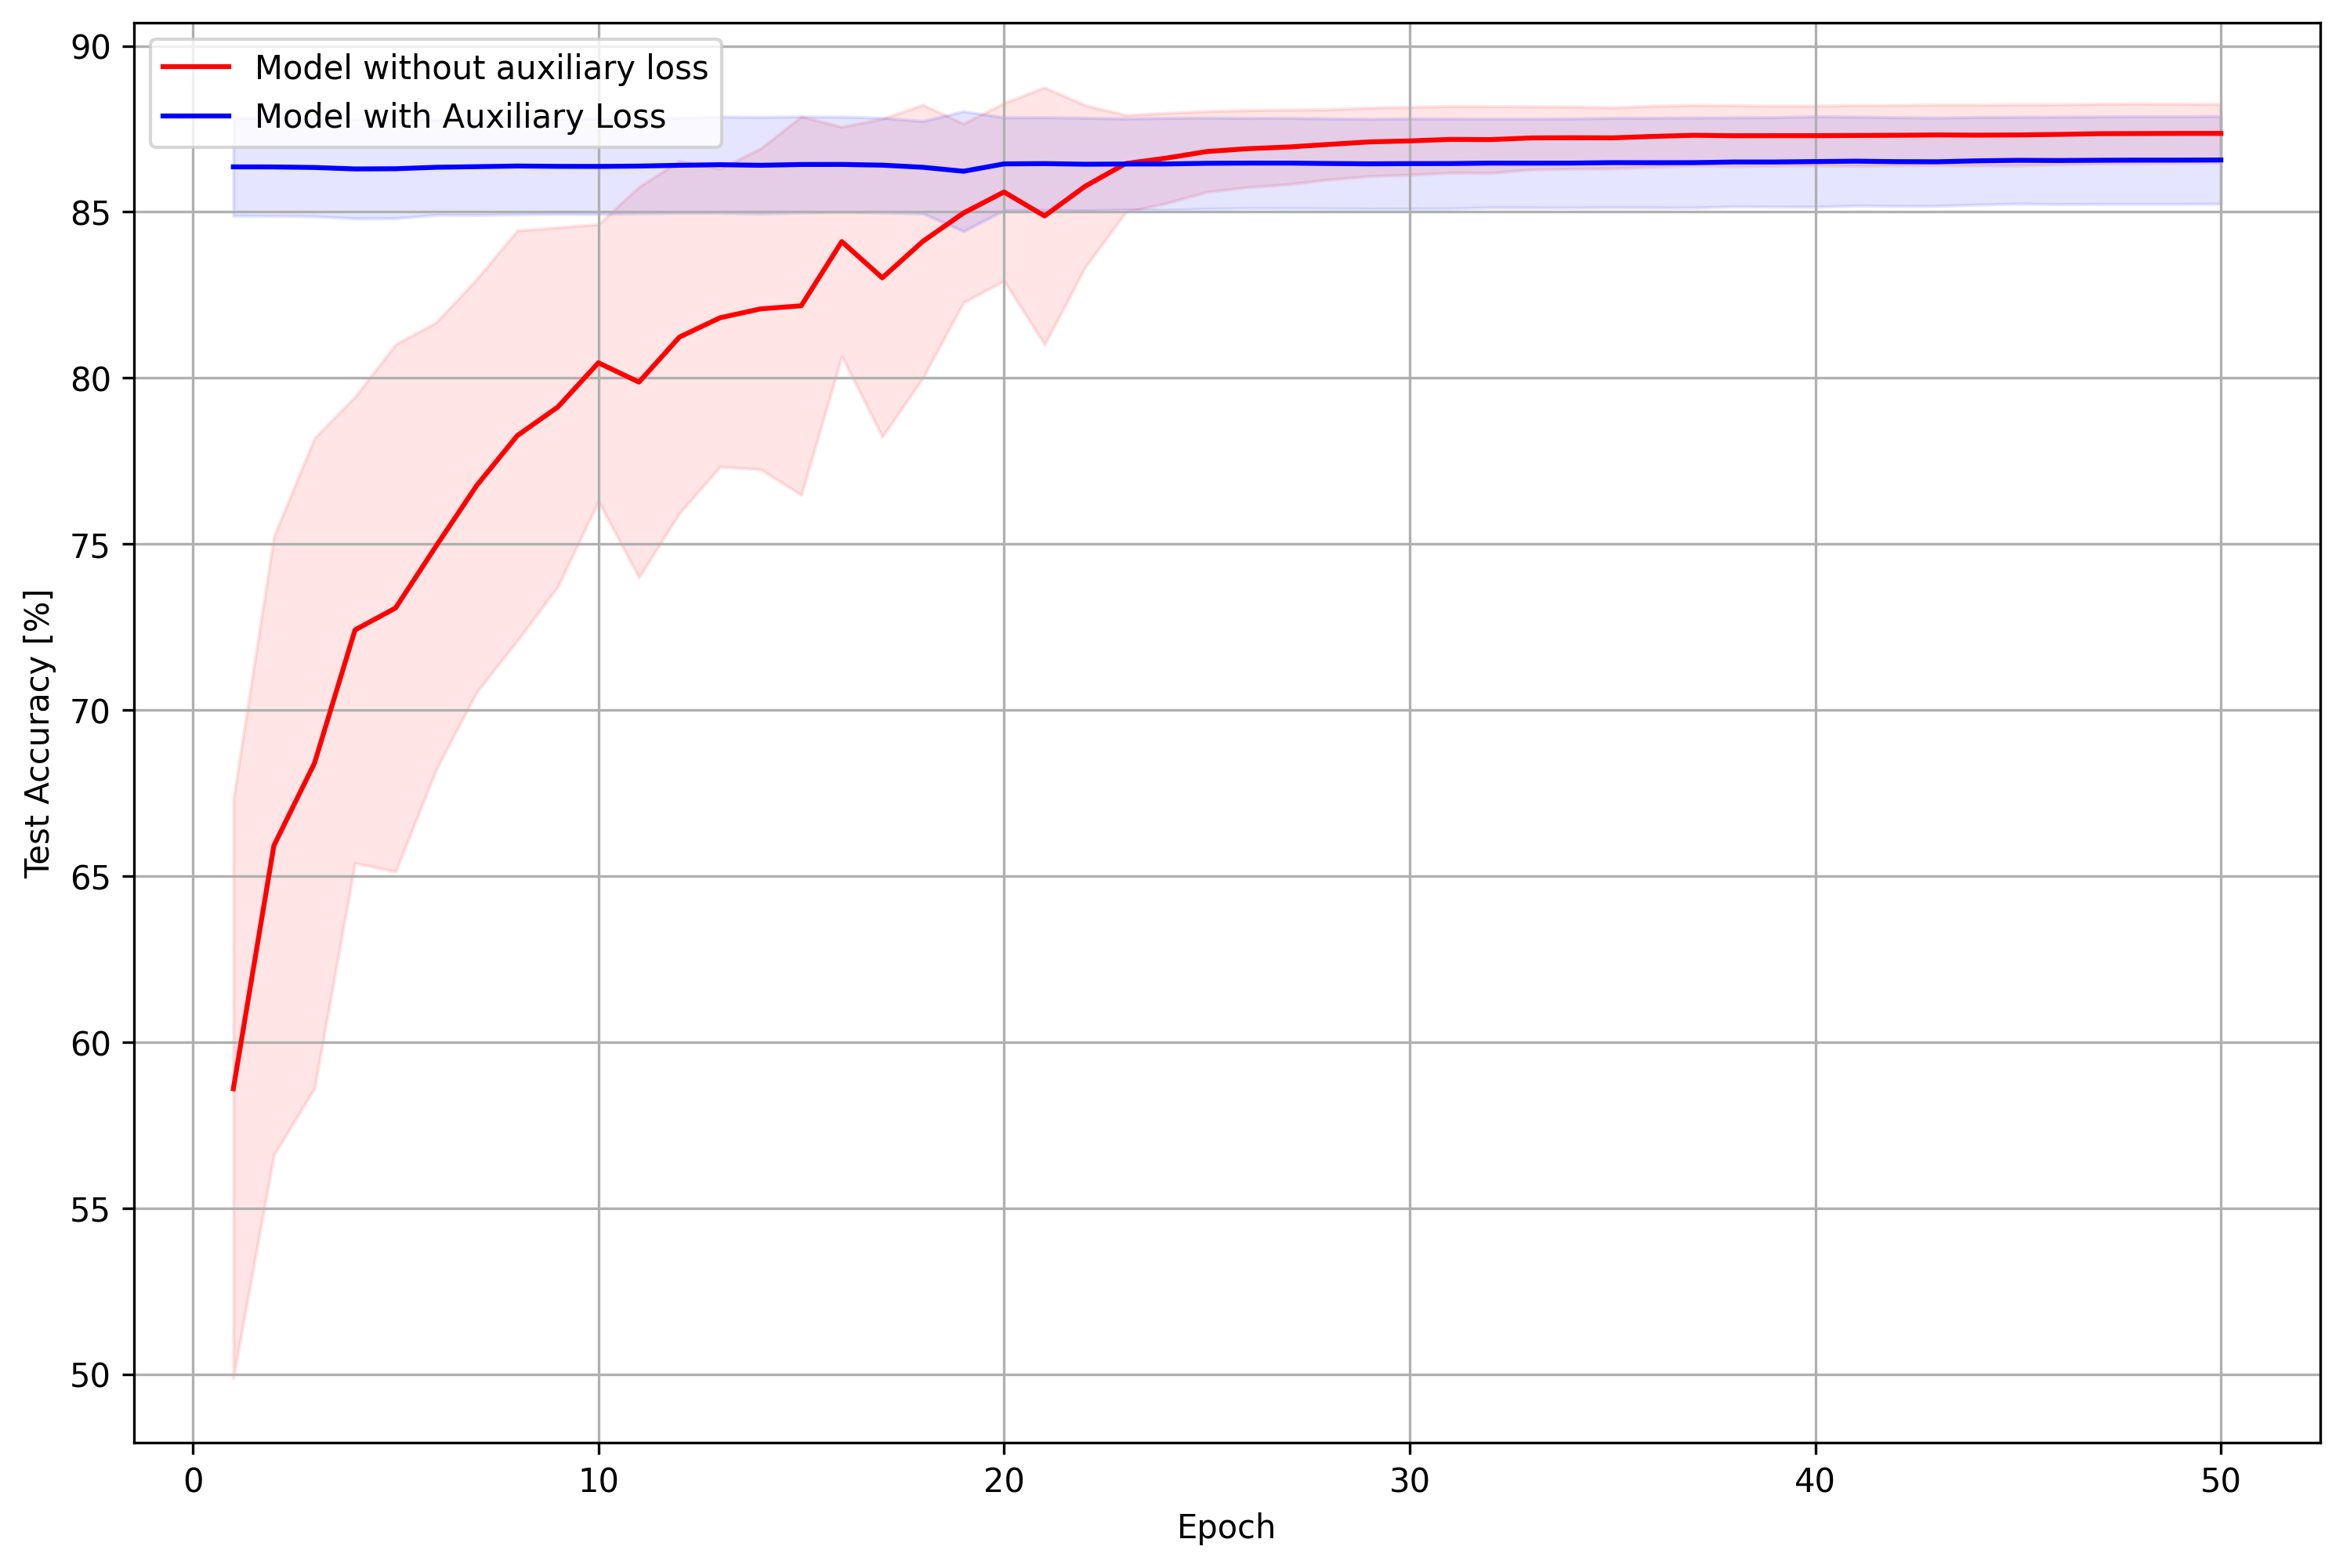

In [43]:
plot('Model without auxiliary loss', 'Model with Auxiliary Loss', 'deep_model_classes', 50, test_acc_1_3, test_acc_2_3)

In [17]:
from time import perf_counter

nb_round = 5
N = 1000
# epochs = 50

test_acc_1_3 = []
time_1_3 = []
test_acc_2_3 = []
time_2_3 = []

lr, nb_epochs, batch_size = 3e-4, 50, 50


for i in range(nb_round):
  
  print(i)
  # Dataset
  torch.set_default_tensor_type(torch.cuda.FloatTensor if torch.cuda.is_available()
                                else torch.FloatTensor)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  # print(device)

  train_pairs, train_target, train_classes, test_pairs, test_target, test_classes = generate_pair_sets(
      1000)
  train_pairs = train_pairs.to(device)
  train_target = train_target.to(device)
  train_classes = train_classes.to(device)
  test_pairs = test_pairs.to(device)
  test_target = test_target.to(device)
  test_classes = test_classes.to(device)
  # Models
  model1 = Net1_deep()  #  change here to different model
  model2 = Net1_deep_classes()  #  change here to different model

  start = perf_counter()
  test_acc_1_3.append(training_model(model1, train_pairs, train_target, train_classes, test_pairs,
                    test_target, eta=0.01, epochs=50, batch_size=batch_size, auxiliary_loss=0))
  end = perf_counter()
  time_1_3.append(end-start)

  start = perf_counter()
  test_acc_2_3.append(training_model(model2, train_pairs, train_target, train_classes, test_pairs,
                                   test_target, eta=3e-4, epochs=500, batch_size=batch_size, auxiliary_loss=2))
  end = perf_counter()
  time_2_3.append(end-start)
print('finish')

0
Epoch # 1 / Train accuracy (%): 73.70 / Test accuracy (%): 72.70
Epoch # 2 / Train accuracy (%): 75.40 / Test accuracy (%): 73.30
Epoch # 3 / Train accuracy (%): 64.70 / Test accuracy (%): 58.80
Epoch # 4 / Train accuracy (%): 73.20 / Test accuracy (%): 67.10
Epoch # 5 / Train accuracy (%): 80.90 / Test accuracy (%): 76.90
Epoch # 6 / Train accuracy (%): 82.70 / Test accuracy (%): 79.80
Epoch # 7 / Train accuracy (%): 83.50 / Test accuracy (%): 80.50
Epoch # 8 / Train accuracy (%): 85.30 / Test accuracy (%): 80.60
Epoch # 9 / Train accuracy (%): 87.20 / Test accuracy (%): 81.80
Epoch # 10 / Train accuracy (%): 88.80 / Test accuracy (%): 82.50
Epoch # 11 / Train accuracy (%): 90.90 / Test accuracy (%): 83.60
Epoch # 12 / Train accuracy (%): 92.30 / Test accuracy (%): 84.10
Epoch # 13 / Train accuracy (%): 93.50 / Test accuracy (%): 84.30
Epoch # 14 / Train accuracy (%): 95.40 / Test accuracy (%): 84.40
Epoch # 15 / Train accuracy (%): 82.40 / Test accuracy (%): 77.30
Epoch # 16 / Trai